In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

In [2]:
import matplotlib as mpl
mpl.rcParams['svg.fonttype'] = 'none'

## ECOLOGICAL DRIFT: temporal dynamics

In [3]:
def construction_stress_exponential(T,dt,d1,d2,i_min,i_max):
    # d1: mean duration of a stress
    # d2: mean duration without stress
    # i_min, i_max: min and max stress intensity
    
    stress=np.array([])
    
    while np.size(stress)<int(T/dt):
        D1=np.random.exponential(d1)
        D2=np.random.exponential(d2)
        stress=np.concatenate((stress,np.zeros(int(D2/dt)),np.repeat(np.random.uniform(i_min,i_max),int(D1/dt))))
    
    return stress[:(int(T/dt)+1)]

In [7]:
def replication(B,dt,r):
    # dt: time step
    # r: replication rate

    B=np.int64(B)
    B=np.maximum(B,0)
    G=np.random.binomial(B,r*dt)
    return G

def lyse_stress(B,dt,t,d,s):
    # dt: time step
    # d: deat rate
    # s: resistance rate
    B=np.int64(B)
    B=np.maximum(B,0)
    
    N=np.sum(B)
    L=np.random.binomial(B,(N*d+f2(t,s))*dt)
    return L

def infection(B,dt,a):
    # dt: time step
    # a: plasmid transfer rate
    B=np.int64(B)
    B=np.maximum(B,0)
    
    I=np.random.binomial(B[0],B[1:]*a*dt)
    return I

def transfert_vertical(B,e):
    # dt: time step
    # e: plasmid vertial transfer rate
    B=np.int64(B)
    B=np.maximum(B,0)
    D=np.random.binomial(B,e)
    return D

In [8]:
def mges_incompatibles_stochastique(B0, dt, T, r, e, d, a, s, n_saved=1000):
    nb_species = B0.size
    n_steps = int(T / dt)
    save_interval = 10000
    save_interval = max(1, n_steps // n_saved)

    B = np.zeros((n_saved, nb_species))
    B_current = B0.copy()

    save_index = 0
    for t in range(1, n_steps):
        # Local processes
        R = replication(B_current, dt, r)
        RP = transfert_vertical(R[1:], e)
        RNP = R[1:] - RP
        L = lyse_stress(B_current, dt, t, d, s)
        I = infection(B_current, dt, a)

        # Updating variables
        B_next = np.zeros_like(B_current)
        B_next[1:] = B_current[1:] + RP - L[1:] + I
        B_next[0] = B_current[0] + R[0] - L[0] - np.sum(I) + np.sum(RNP)

        # Zeors
        np.maximum(B_next, 0, out=B_next)

        # Updating variables
        B_current = B_next

        # Saving
        if t % save_interval == 0 and save_index < n_saved:
            B[save_index] = B_current
            save_index += 1

    return B

In [9]:
def f2(t,s):
    return S[t]*(1-s)
T=250000
dt=0.1
nb_mges=200
d=1e-6
a=1e-5
e=0.9
r=np.concatenate(([1],np.repeat(0.99,nb_mges)))
s=np.repeat(0,nb_mges+1)
B0=np.concatenate(([1e5],np.repeat(10,nb_mges)))
S=construction_stress_exponential(T,dt,50,50,0.9,0.9)
#print(np.shape(S))

B=mges_incompatibles_stochastique(B0,dt,T,r,e,d,a,s,2000)
print(np.shape(B))

(2000, 201)


In [10]:
B_freq=B[:,1:]
B_freq=np.divide(B_freq,np.reshape(np.sum(B_freq,axis=1),(-1,1)))
np.shape(B_freq)

/tmp/ipykernel_8841/1926959944.py:2: RuntimeWarning: invalid value encountered in divide
  B_freq=np.divide(B_freq,np.reshape(np.sum(B_freq,axis=1),(-1,1)))


(2000, 200)

In [11]:
nb_time=np.shape(B)[0]
t=np.linspace(0,T,nb_time)
idx = np.argmin(np.abs(t - 25000))
nb_mges_inter=np.sum(B[idx,1:]>0)
print(nb_mges_inter)

9


/tmp/ipykernel_8841/2551941566.py:20: RuntimeWarning: divide by zero encountered in log10
  axs[0].plot(t,np.log10(plasmid_richness),color='black',linewidth=4)#color(np.where((B_freq[-2]>0)==True)[0]),linewidth=4)


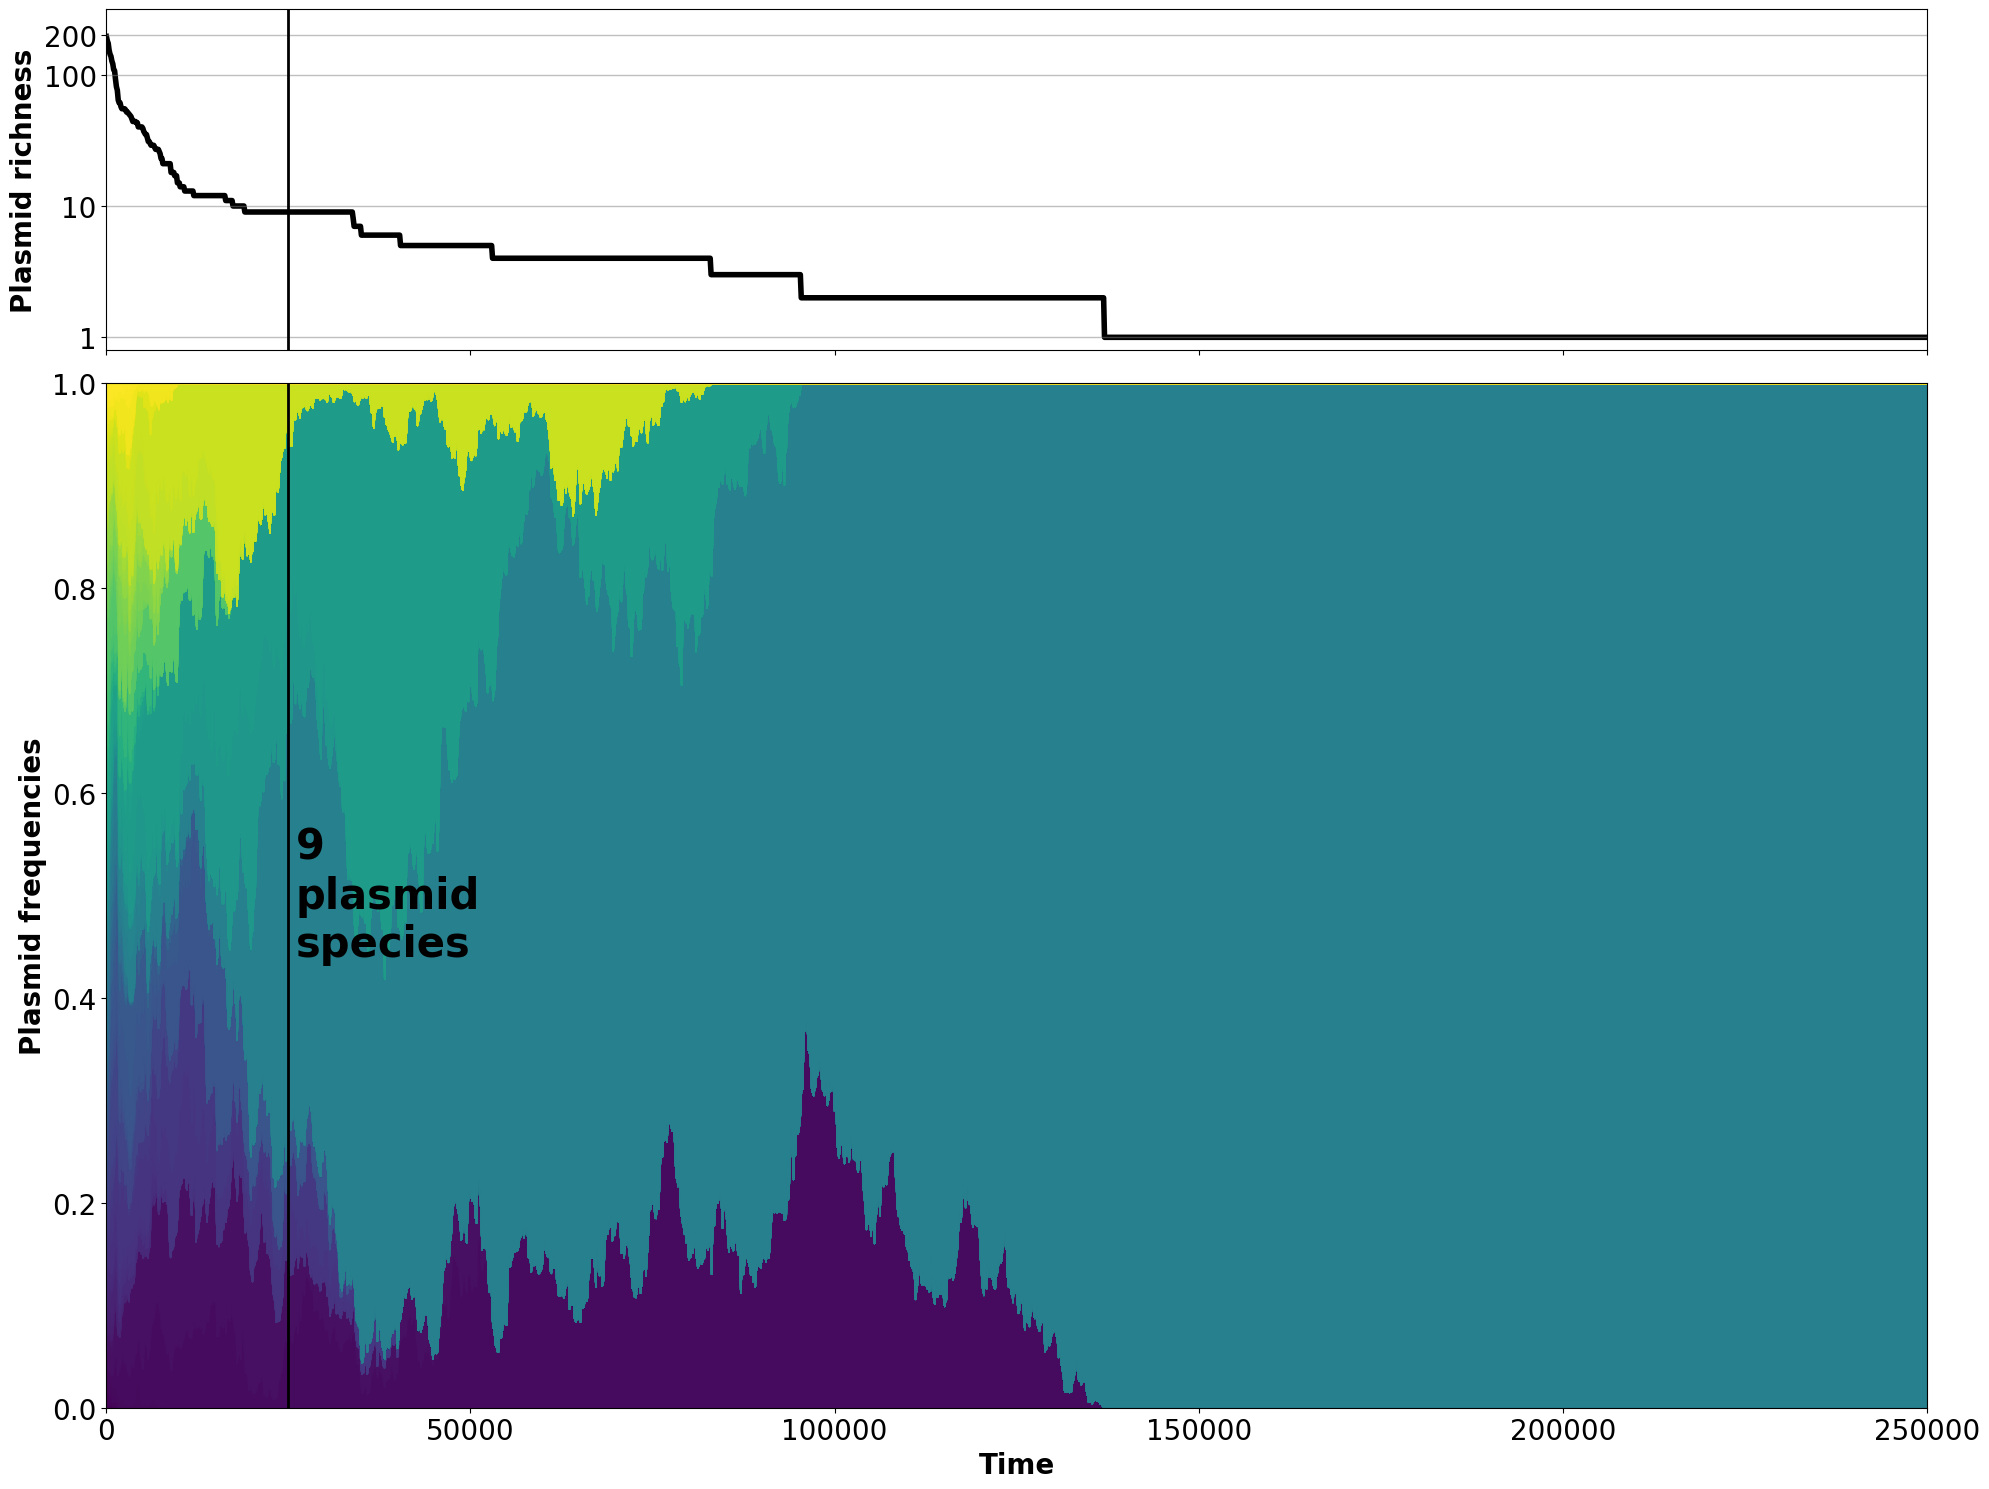

In [13]:
nb_final_mges=np.sum(B[-4,1:]>0)
nb_time=np.shape(B)[0]
tmp=B[-1,1:]
tmp=tmp[tmp>0]
tmp=tmp/np.sum(tmp)
tmp=np.cumsum(tmp)
tmp=np.concatenate(([0],tmp))

xticks=np.arange(0,T+1,2e5)
t=np.linspace(0,T,nb_time)

plasmid_richness=np.zeros(nb_time)
for i in range(nb_time):
    plasmid_richness[i]=np.sum(B[i,1:]>0)
    
color=plt.get_cmap("viridis",nb_mges)
fig, axs = plt.subplots(2,1,figsize=(20,15),sharex=True,sharey=False,gridspec_kw={'height_ratios': [1, 3]})

axs[0].plot(t,np.log10(plasmid_richness),color='black',linewidth=4)#color(np.where((B_freq[-2]>0)==True)[0]),linewidth=4)
axs[0].set_ylabel('Plasmid richness',size=20,weight='bold')
axs[0].hlines(np.log10([1,10,100,200]),0,T,color="grey",alpha=0.5,linewidth=1)
axs[0].set_yticks(np.log10([1,10,100,200]))
axs[0].set_yticklabels([1,10,100,200],rotation=0,size=20)
axs[0].vlines(25000,-1,3,color='black',linewidth=2)
axs[0].set_ylim(-0.1,2.5)

for i in range(nb_mges):
    axs[1].fill_between(t,np.sum(B_freq[:,:i],axis=1),np.sum(B_freq[:,:i+1],axis=1),color=color(i))

axs[1].set_xlabel('Time',size=20,weight='bold')
axs[1].set_ylabel('Plasmid frequencies',size=20,weight='bold')
axs[1].tick_params("both",labelsize=20)
axs[1].set_xlim(0,T)
axs[1].set_ylim(0,1)
#axs[1].set_xticks(xticks)
#axs[1].set_xticklabels(['0','2e5','4e5','6e5','8e5','1e6'])
axs[1].vlines(25000,-1,3,color='black',linewidth=2)
axs[1].text(26000,0.5,str(nb_mges_inter)+'\nplasmid\nspecies',ha='left',va='center',fontsize=30,color="black",weight="bold")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## FITTING OBSERVED DATA

In [22]:
data_plasmid_1=pd.read_csv('observed_data/PTU_count.tsv',sep='\t')

In [4]:
repertory='simulated_data/neutral_model_sensibility_analysis/'

In [5]:
nb_replicats=25
sub_repertory=repertory+"dispersion=0.0_innovation=0.0"
plasmids_abundances_1=np.zeros((4*nb_replicats,1000))
for i in range(nb_replicats):
    B = np.loadtxt(sub_repertory+'/simulation_'+str(i)+".csv", delimiter=',')
    nb_mges_final=np.shape(B)[1]-1
    nb_community=np.shape(B)[0]
    B=B[:,1:]
    proba=B/np.sum(B,1).reshape((nb_community,-1))
    for j in range(nb_community):
        plasmids_abundances_1[4*i+j,:nb_mges_final]=np.flip(np.sort(np.random.multinomial(4411,proba[j])))

In [6]:
nb_replicats=25
nb_community=1
sub_repertory=repertory+"dispersion=0.001_innovation=0.0"
plasmids_abundances_2=np.zeros((4*nb_replicats,1000))
for i in range(nb_replicats):
    B = np.loadtxt(sub_repertory+'/simulation_'+str(i)+".csv", delimiter=',')
    nb_mges_final=np.shape(B)[1]-1
    nb_community=np.shape(B)[0]
    B=B[:,1:]
    proba=B/np.sum(B,1).reshape((nb_community,-1))
    for j in range(nb_community):
        plasmids_abundances_2[4*i+j,:nb_mges_final]=np.flip(np.sort(np.random.multinomial(4411,proba[j])))

In [7]:
nb_replicats=25
nb_community=1
sub_repertory=repertory+"dispersion=0.0_innovation=1.25e-05"
plasmids_abundances_3=np.zeros((4*nb_replicats,1000))
for i in range(nb_replicats):
    B = np.loadtxt(sub_repertory+'/simulation_'+str(i)+".csv", delimiter=',')
    nb_mges_final=np.shape(B)[1]-1
    nb_community=np.shape(B)[0]
    B=B[:,1:]
    proba=B/np.sum(B,1).reshape((nb_community,-1))
    for j in range(nb_community):
        plasmids_abundances_3[4*i+j,:nb_mges_final]=np.flip(np.sort(np.random.multinomial(4411,proba[j])))

In [8]:
nb_replicats=25
nb_community=1
sub_repertory=repertory+"dispersion=0.001_innovation=1.25e-05"
plasmids_abundances_4=np.zeros((4*nb_replicats,1000))
for i in range(nb_replicats):
    B = np.loadtxt(sub_repertory+'/simulation_'+str(i)+".csv", delimiter=',')
    nb_mges_final=np.shape(B)[1]-1
    nb_community=np.shape(B)[0]
    B=B[:,1:]
    proba=B/np.sum(B,1).reshape((nb_community,-1))
    for j in range(nb_community):
        plasmids_abundances_4[4*i+j,:nb_mges_final]=np.flip(np.sort(np.random.multinomial(4411,proba[j])))

In [9]:
nb_replicats=25
nb_community=1
sub_repertory=repertory+"dispersion=0.001_innovation=1e-05"
plasmids_abundances_tot=np.zeros((nb_replicats,1000))
for i in range(nb_replicats):
    B = np.loadtxt(sub_repertory+'/simulation_'+str(i)+".csv", delimiter=',')
    nb_mges_final=np.shape(B)[1]-1
    nb_community=np.shape(B)[0]
    B=B[:,1:]
    proba=B/np.sum(B,1).reshape((nb_community,-1))
    taille_effectif=np.random.multinomial(4411,np.sum(B,1)/np.sum(B))
    B_echantillon=np.zeros(nb_mges_final)
    for j in range(nb_community):
        B_echantillon=B_echantillon+np.random.multinomial(taille_effectif[j],proba[j])
    res=np.flip(np.sort(B_echantillon))
    ## stockage
    plasmids_abundances_tot[i,:nb_mges_final]=res

### Median number of plasmid species

In [10]:
median_plasmids_abundances_1=np.quantile(plasmids_abundances_1,0.5,axis=0)
median_plasmids_abundances_2=np.quantile(plasmids_abundances_2,0.5,axis=0)
median_plasmids_abundances_3=np.quantile(plasmids_abundances_3,0.5,axis=0)
median_plasmids_abundances_4=np.quantile(plasmids_abundances_4,0.5,axis=0)

In [11]:
m1=np.sum(median_plasmids_abundances_1>0)
m2=np.sum(median_plasmids_abundances_2>0)
m3=np.sum(median_plasmids_abundances_3>0)
m4=np.sum(median_plasmids_abundances_4>0)

In [12]:
print(m1)
print(m2)
print(m3)
print(m4)

7
32
21
71


Log10 transformation. 

In [13]:
median_plasmids_abundances_1=np.log10(median_plasmids_abundances_1)
median_plasmids_abundances_2=np.log10(median_plasmids_abundances_2)
median_plasmids_abundances_3=np.log10(median_plasmids_abundances_3)
median_plasmids_abundances_4=np.log10(median_plasmids_abundances_4)

/tmp/ipykernel_13510/1100531625.py:1: RuntimeWarning: divide by zero encountered in log10
  median_plasmids_abundances_1=np.log10(median_plasmids_abundances_1)
/tmp/ipykernel_13510/1100531625.py:2: RuntimeWarning: divide by zero encountered in log10
  median_plasmids_abundances_2=np.log10(median_plasmids_abundances_2)
/tmp/ipykernel_13510/1100531625.py:3: RuntimeWarning: divide by zero encountered in log10
  median_plasmids_abundances_3=np.log10(median_plasmids_abundances_3)
/tmp/ipykernel_13510/1100531625.py:4: RuntimeWarning: divide by zero encountered in log10
  median_plasmids_abundances_4=np.log10(median_plasmids_abundances_4)


### Quantile number of plasmid species

In [14]:
Q1_plasmids_abundances_1=np.log10(np.quantile(plasmids_abundances_1,0.25,axis=0))
Q1_plasmids_abundances_2=np.log10(np.quantile(plasmids_abundances_2,0.25,axis=0))
Q1_plasmids_abundances_3=np.log10(np.quantile(plasmids_abundances_3,0.25,axis=0))
Q1_plasmids_abundances_4=np.log10(np.quantile(plasmids_abundances_4,0.25,axis=0))

/tmp/ipykernel_13510/4031225454.py:1: RuntimeWarning: divide by zero encountered in log10
  Q1_plasmids_abundances_1=np.log10(np.quantile(plasmids_abundances_1,0.25,axis=0))
/tmp/ipykernel_13510/4031225454.py:2: RuntimeWarning: divide by zero encountered in log10
  Q1_plasmids_abundances_2=np.log10(np.quantile(plasmids_abundances_2,0.25,axis=0))
/tmp/ipykernel_13510/4031225454.py:3: RuntimeWarning: divide by zero encountered in log10
  Q1_plasmids_abundances_3=np.log10(np.quantile(plasmids_abundances_3,0.25,axis=0))
/tmp/ipykernel_13510/4031225454.py:4: RuntimeWarning: divide by zero encountered in log10
  Q1_plasmids_abundances_4=np.log10(np.quantile(plasmids_abundances_4,0.25,axis=0))


In [15]:
Q1_plasmids_abundances_1[Q1_plasmids_abundances_1==-np.inf]=-1000
Q1_plasmids_abundances_2[Q1_plasmids_abundances_2==-np.inf]=-1000
Q1_plasmids_abundances_3[Q1_plasmids_abundances_3==-np.inf]=-1000
Q1_plasmids_abundances_4[Q1_plasmids_abundances_4==-np.inf]=-1000

In [16]:
Q1_plasmids_abundances_1[m1:]=np.nan
Q1_plasmids_abundances_2[m2:]=np.nan
Q1_plasmids_abundances_3[m3:]=np.nan
Q1_plasmids_abundances_4[m4:]=np.nan

In [17]:
Q3_plasmids_abundances_1=np.log10(np.quantile(plasmids_abundances_1,0.75,axis=0))
Q3_plasmids_abundances_2=np.log10(np.quantile(plasmids_abundances_2,0.75,axis=0))
Q3_plasmids_abundances_3=np.log10(np.quantile(plasmids_abundances_3,0.75,axis=0))
Q3_plasmids_abundances_4=np.log10(np.quantile(plasmids_abundances_4,0.75,axis=0))

/tmp/ipykernel_13510/801731440.py:1: RuntimeWarning: divide by zero encountered in log10
  Q3_plasmids_abundances_1=np.log10(np.quantile(plasmids_abundances_1,0.75,axis=0))
/tmp/ipykernel_13510/801731440.py:2: RuntimeWarning: divide by zero encountered in log10
  Q3_plasmids_abundances_2=np.log10(np.quantile(plasmids_abundances_2,0.75,axis=0))
/tmp/ipykernel_13510/801731440.py:3: RuntimeWarning: divide by zero encountered in log10
  Q3_plasmids_abundances_3=np.log10(np.quantile(plasmids_abundances_3,0.75,axis=0))
/tmp/ipykernel_13510/801731440.py:4: RuntimeWarning: divide by zero encountered in log10
  Q3_plasmids_abundances_4=np.log10(np.quantile(plasmids_abundances_4,0.75,axis=0))


### Metacommunity Q1, Q2, Q3

In [18]:
median_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.5,axis=0))
m5=np.sum(median_plasmids_abundances_tot>=0)
print(m5)

Q1_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.25,axis=0))
Q1_plasmids_abundances_tot[Q1_plasmids_abundances_tot==-np.inf]=-1000
Q3_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.75,axis=0))
Q3_plasmids_abundances_tot[Q3_plasmids_abundances_tot==-np.inf]=-1000

Q1_plasmids_abundances_tot[m5:]=np.nan

68


/tmp/ipykernel_13510/1385096655.py:1: RuntimeWarning: divide by zero encountered in log10
  median_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.5,axis=0))
/tmp/ipykernel_13510/1385096655.py:5: RuntimeWarning: divide by zero encountered in log10
  Q1_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.25,axis=0))
/tmp/ipykernel_13510/1385096655.py:7: RuntimeWarning: divide by zero encountered in log10
  Q3_plasmids_abundances_tot=np.log10(np.quantile(plasmids_abundances_tot,0.75,axis=0))


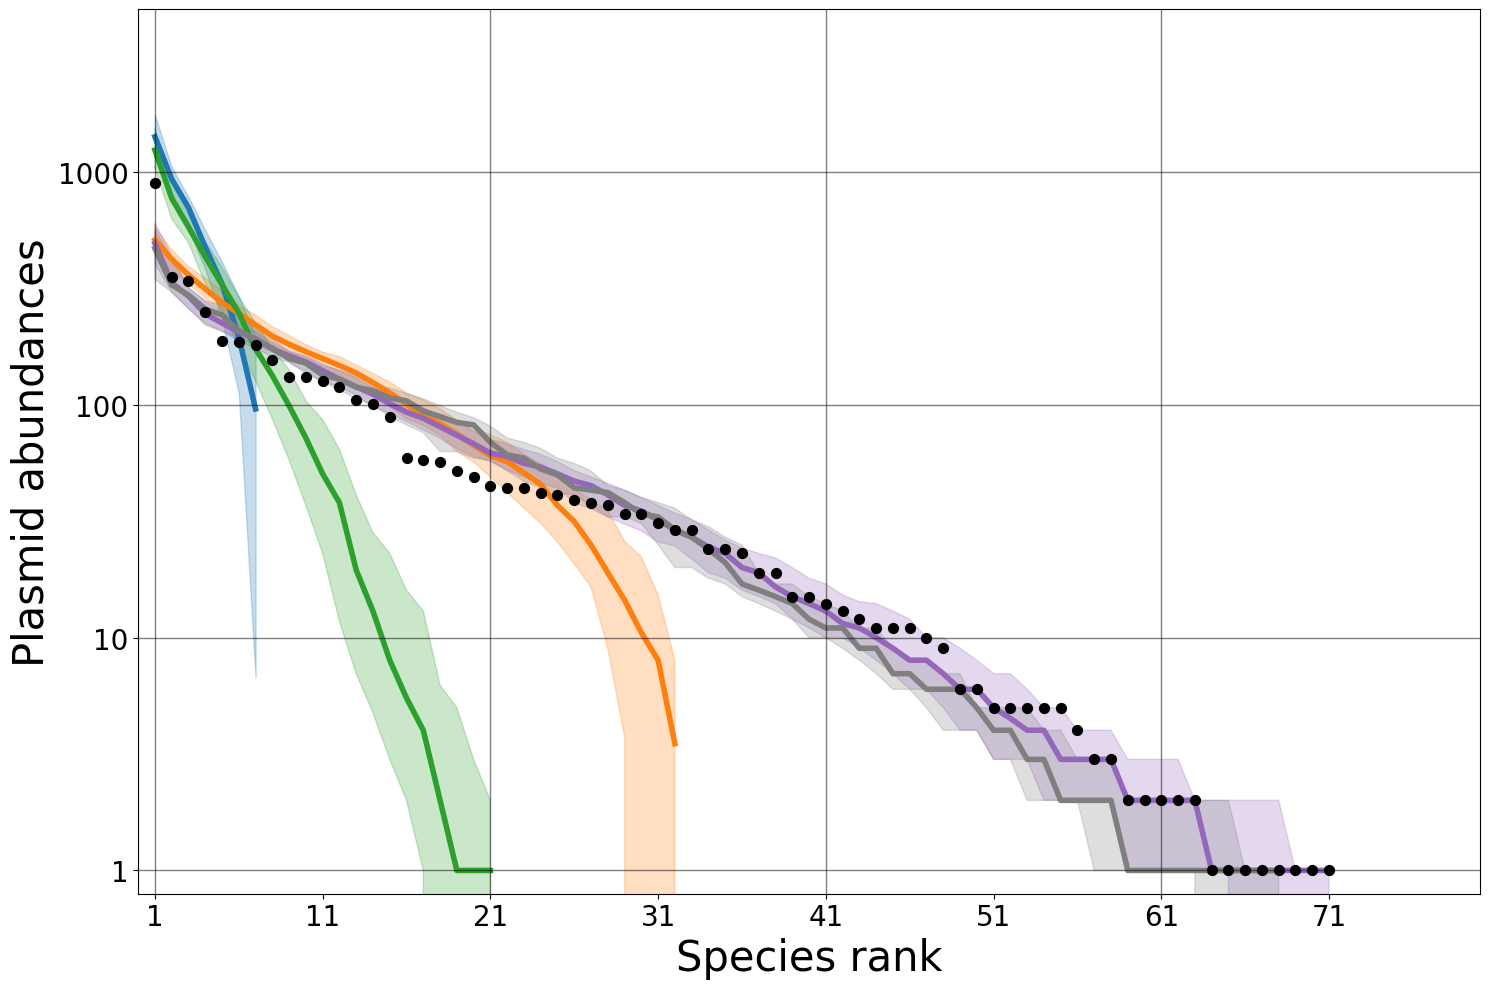

In [24]:
transparence=0.5
alpha=0.25
nb_plasmides=np.shape(data_plasmid_1)[0]

## Figures 
fig, axs= plt.subplots(1,1,figsize=(15,10),sharex=True)

axs.plot(np.arange(1,1000+1),median_plasmids_abundances_1,color="tab:blue",label="Ecological drift",linewidth=4)
axs.plot(np.arange(1,1000+1),median_plasmids_abundances_2,color="tab:orange",label="Dispersion only",linewidth=4)
axs.plot(np.arange(1,1000+1),median_plasmids_abundances_3,color="tab:green",label="Innovation only",linewidth=4)
axs.plot(np.arange(1,1000+1),median_plasmids_abundances_4,color="tab:purple",label="Dispersion & innovation",linewidth=4)

axs.fill_between(np.arange(1,1000+1), Q1_plasmids_abundances_1, Q3_plasmids_abundances_1,color="tab:blue",linewidth=1,alpha=alpha)
axs.fill_between(np.arange(1,1000+1), Q1_plasmids_abundances_2, Q3_plasmids_abundances_2,color="tab:orange",linewidth=1,alpha=alpha)
axs.fill_between(np.arange(1,1000+1), Q1_plasmids_abundances_3, Q3_plasmids_abundances_3,color="tab:green",linewidth=1,alpha=alpha)
axs.fill_between(np.arange(1,1000+1), Q1_plasmids_abundances_4, Q3_plasmids_abundances_4,color="tab:purple",linewidth=1,alpha=alpha)

axs.plot(np.arange(1,1000+1),median_plasmids_abundances_tot,color="tab:gray",label="Dispersion & innovation\n(metacommunity level)",linewidth=4)
axs.fill_between(np.arange(1,1000+1), Q1_plasmids_abundances_tot, Q3_plasmids_abundances_tot,color="tab:gray",linewidth=1,alpha=alpha)

axs.scatter(np.arange(1,nb_plasmides+1),np.log10(np.flip(np.sort(data_plasmid_1['count']))),alpha=1,color='black',s=50,label="Observed data",zorder=4)
axs.set_ylabel('Plasmid abundances',size=30)
axs.set_xlabel('Species rank',size=30)
axs.set_xticks(ticks=np.arange(1,1000,10))
axs.set_yticks(ticks=[0,1,2,3,4]) 
axs.set_yticklabels(labels=[1,10,100,1000,10000])
axs.tick_params(axis='both', labelsize=20)
axs.plot([-10, 1000], [4, 4],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [3, 3],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [2, 2],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [1, 1],color="black",linewidth=1,alpha=transparence)
axs.plot([-10, 1000], [0, 0],color="black",linewidth=1,alpha=transparence)

axs.plot([1, 1], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([21, 21], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([41, 41], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([61, 61], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.plot([81, 81], [-1, 5],color="black",linewidth=1,alpha=transparence)
axs.set_xlim(0,80)
axs.set_ylim(-0.1,3.7)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

## RICHNESS DIFFERENCES

In [25]:
plasmid_richness=np.zeros((4,nb_replicats*4))
for i in range(nb_replicats*4):
    plasmid_richness[0,i]=np.where(plasmids_abundances_1[i]==0)[0][0]
    plasmid_richness[1,i]=np.where(plasmids_abundances_2[i]==0)[0][0]
    plasmid_richness[2,i]=np.where(plasmids_abundances_3[i]==0)[0][0]
    plasmid_richness[3,i]=np.where(plasmids_abundances_4[i]==0)[0][0]

In [26]:
plasmid_richness_pd=pd.DataFrame({'group' : np.repeat(['Ecological drift','Dispersion only','Innovation only','Dispersion & innovation'],nb_replicats*4),
                                  'value' : np.reshape(plasmid_richness,(1,-1))[0]})

### ANOVA test

In [31]:
model = ols('value ~ group', data=plasmid_richness_pd).fit()

# ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

             sum_sq     df            F         PR(>F)
group     227193.98    3.0  2741.936859  1.934638e-264
Residual   10937.38  396.0          NaN            NaN


### Tukey test

In [32]:
tukey = pairwise_tukeyhsd(
    endog=plasmid_richness_pd['value'],      
    groups=plasmid_richness_pd['group'],     
    alpha=0.05                               
)
results_df = pd.DataFrame({
    "group1": tukey.groupsunique[tukey._multicomp.pairindices[0]],
    "group2": tukey.groupsunique[tukey._multicomp.pairindices[1]],
    "meandiff": tukey.meandiffs,
    "p-adj": tukey.pvalues,  # Valeurs non arrondies
    "lower": tukey.confint[:, 0],
    "upper": tukey.confint[:, 1],
    "reject": tukey.reject
})


pd.set_option('display.float_format', lambda x: f'{x:.18e}')  # plus de décimales
print(results_df)

                    group1            group2                  meandiff  \
0  Dispersion & innovation   Dispersion only -3.996999999999999886e+01   
1  Dispersion & innovation  Ecological drift -6.392000000000000171e+01   
2  Dispersion & innovation   Innovation only -5.039000000000000057e+01   
3          Dispersion only  Ecological drift -2.394999999999999929e+01   
4          Dispersion only   Innovation only -1.042000000000000171e+01   
5         Ecological drift   Innovation only  1.352999999999999758e+01   

                     p-adj                     lower  \
0 1.201261312644419377e-13 -4.188751671978600655e+01   
1 1.201261312644419377e-13 -6.583751671978600939e+01   
2 1.201261312644419377e-13 -5.230751671978600825e+01   
3 1.201261312644419377e-13 -2.586751671978600342e+01   
4 1.201261312644419377e-13 -1.233751671978600761e+01   
5 1.201261312644419377e-13  1.161248328021399168e+01   

                      upper  reject  
0 -3.805248328021399118e+01    True  
1 -6.2002483

### Boxplot with differences 

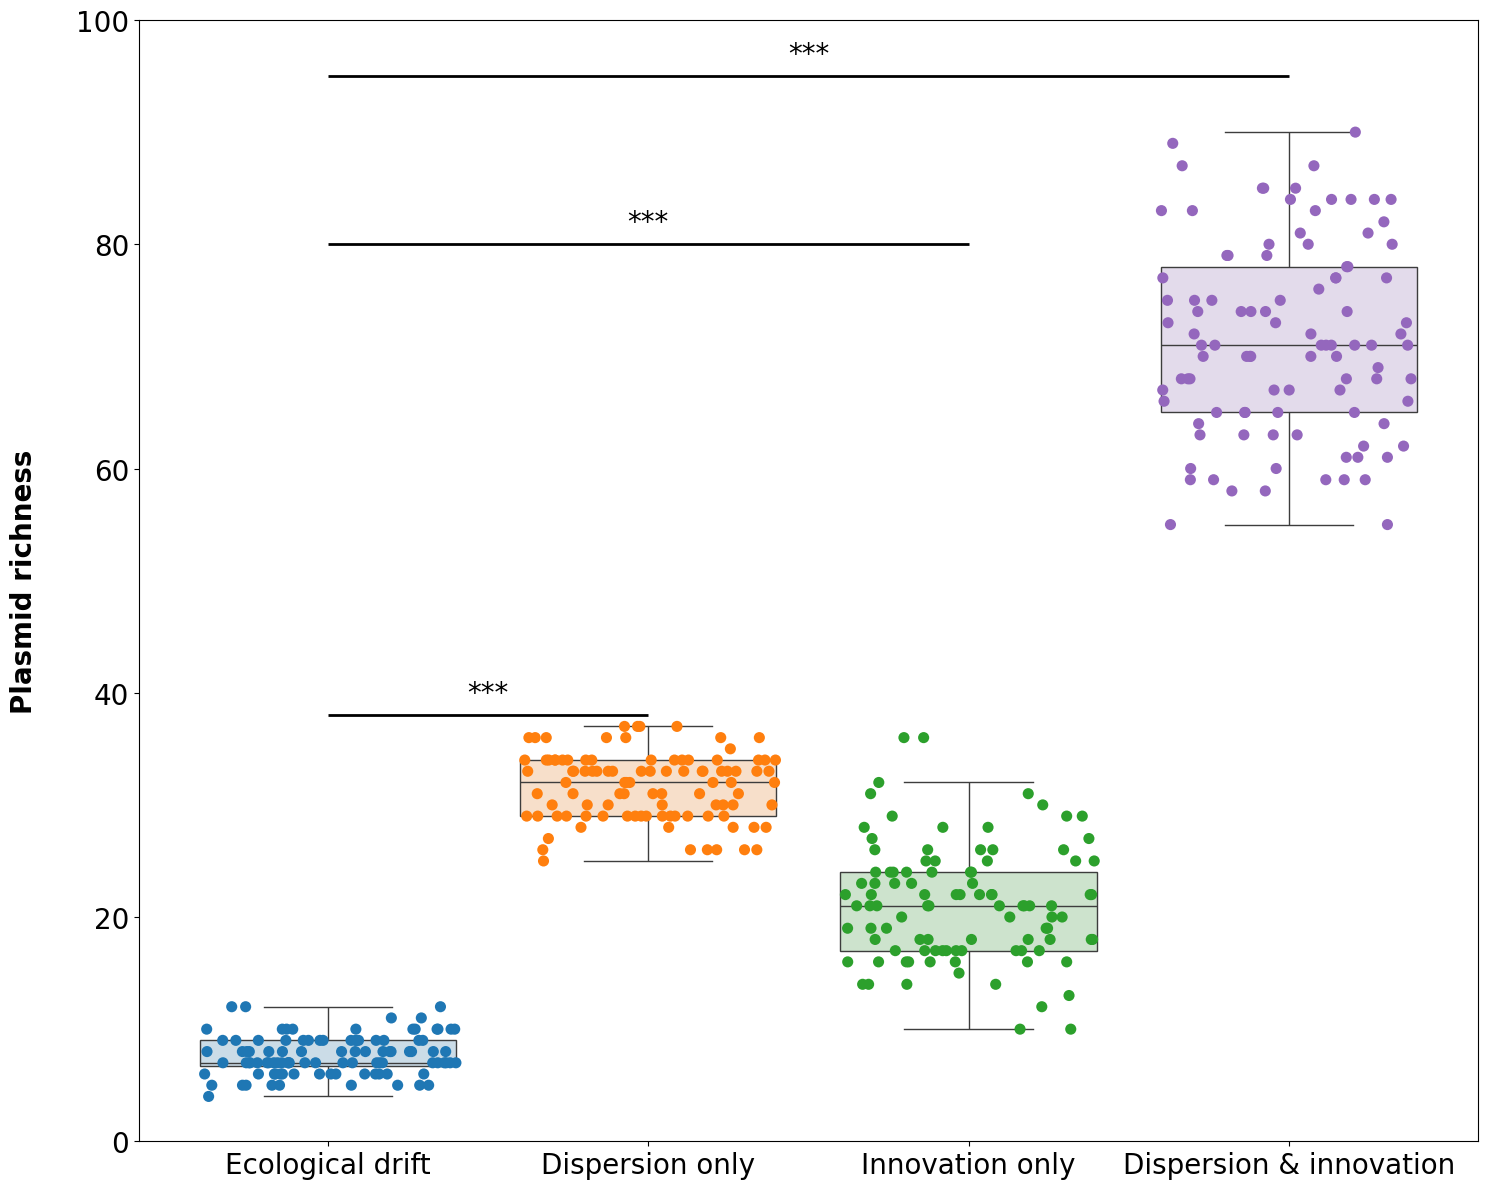

In [35]:
my_pal = {"Ecological drift": "tab:blue", "Dispersion only": "tab:orange", "Innovation only":"tab:green", "Dispersion & innovation": "tab:purple"}

fig, ax = plt.subplots(figsize=(15, 12))
box = sns.boxplot(x='group', y='value',data=plasmid_richness_pd,hue='group',palette=my_pal,ax=ax,showfliers = False)

# Boxplot transparency
for i, patch in enumerate(ax.patches):
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.25))  # alpha = 0.3

strip = sns.stripplot(x='group', y='value',data=plasmid_richness_pd,hue='group',palette=my_pal,jitter=0.4,size=8,ax=ax)

# Axes
ax.set_xlabel('', size=20, weight='bold')
ax.set_ylabel('Plasmid richness\n', size=20, weight='bold')
ax.tick_params("both", labelsize=20)

ax.hlines(38,xmin=0,xmax=1,linewidth=2,color='black')
ax.hlines(80,xmin=0,xmax=2,linewidth=2,color='black')
ax.hlines(95,xmin=0,xmax=3,linewidth=2,color='black')

ax.text(0.5,40,'***',ha='center',va='center',fontsize=20,color="black")
ax.text(1,82,'***',ha='center',va='center',fontsize=20,color="black")
ax.text(1.5,97,'***',ha='center',va='center',fontsize=20,color="black")

ax.set_ylim(0,100)
plt.tight_layout()
plt.show()

## HETEROGENEITY DIFFERENCES

In [36]:
plasmid_simpson=np.zeros((4,nb_replicats*4))
for i in range(nb_replicats*4):
    plasmid_simpson[0,i]=1-np.sum((plasmids_abundances_1[i]/np.sum(plasmids_abundances_1[i]))**2)
    plasmid_simpson[1,i]=1-np.sum((plasmids_abundances_2[i]/np.sum(plasmids_abundances_2[i]))**2)
    plasmid_simpson[2,i]=1-np.sum((plasmids_abundances_3[i]/np.sum(plasmids_abundances_3[i]))**2)
    plasmid_simpson[3,i]=1-np.sum((plasmids_abundances_4[i]/np.sum(plasmids_abundances_4[i]))**2)

In [37]:
plasmid_simpson_pd=pd.DataFrame({'group' : np.repeat(['Ecological drift','Dispersion only','Innovation only','Dispersion & innovation'],nb_replicats*4),
                                  'value' : np.reshape(plasmid_simpson,(1,-1))[0]})

### ANOVA test

In [38]:
model = ols('value ~ group', data=plasmid_simpson_pd).fit()

# ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                           sum_sq                       df  \
group    2.623747663056453572e+00 3.000000000000000000e+00   
Residual 1.310669646545183920e+00 3.960000000000000000e+02   

                                F                   PR(>F)  
group    2.642425514593714411e+02 3.904019749917401027e-94  
Residual                      NaN                      NaN  


### Tukey test

In [39]:
tukey = pairwise_tukeyhsd(
    endog=plasmid_simpson_pd['value'],      
    groups=plasmid_simpson_pd['group'],     
    alpha=0.05                              
)

results_df = pd.DataFrame({
    "group1": tukey.groupsunique[tukey._multicomp.pairindices[0]],
    "group2": tukey.groupsunique[tukey._multicomp.pairindices[1]],
    "meandiff": tukey.meandiffs,
    "p-adj": tukey.pvalues,  # Valeurs non arrondies
    "lower": tukey.confint[:, 0],
    "upper": tukey.confint[:, 1],
    "reject": tukey.reject
})

pd.set_option('display.float_format', lambda x: f'{x:.15e}')  # plus de décimales
print(results_df)

                    group1            group2               meandiff  \
0  Dispersion & innovation   Dispersion only -1.126226292433463e-02   
1  Dispersion & innovation  Ecological drift -1.918182666209111e-01   
2  Dispersion & innovation   Innovation only -1.316062053189198e-01   
3          Dispersion only  Ecological drift -1.805560036965764e-01   
4          Dispersion only   Innovation only -1.203439423945851e-01   
5         Ecological drift   Innovation only  6.021206130199130e-02   

                  p-adj                  lower                  upper  reject  
0 5.099765255397642e-01 -3.225306964734410e-02  9.728543798674834e-03   False  
1 1.201261312644419e-13 -2.128090733439205e-01 -1.708274598979016e-01    True  
2 1.201261312644419e-13 -1.525970120419292e-01 -1.106153985959103e-01    True  
3 1.201261312644419e-13 -2.015468104195859e-01 -1.595651969735670e-01    True  
4 1.201261312644419e-13 -1.413347491175946e-01 -9.935313567157567e-02    True  
5 5.037525951934185e-1

### Boxplot with differences

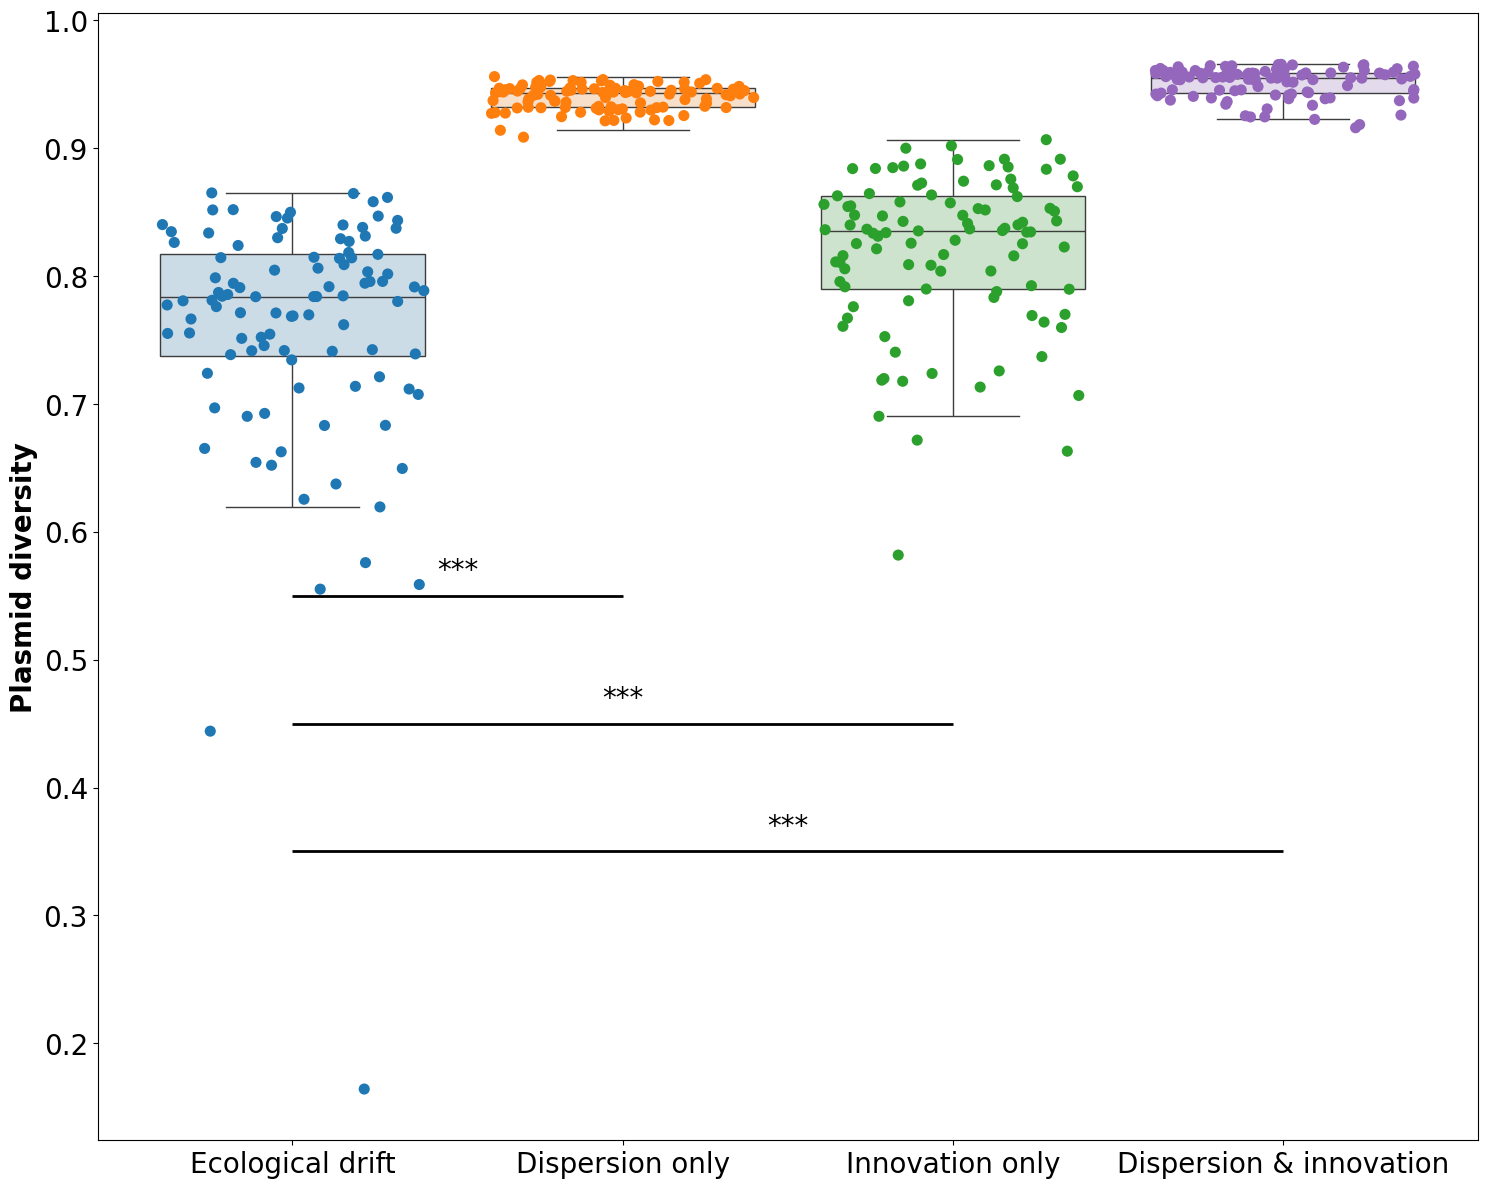

In [40]:
my_pal = {"Ecological drift": "tab:blue", "Dispersion only": "tab:orange", "Innovation only":"tab:green", "Dispersion & innovation": "tab:purple"}

fig, ax = plt.subplots(figsize=(15, 12))
box = sns.boxplot(x='group', y='value',data=plasmid_simpson_pd,hue='group',palette=my_pal,ax=ax,showfliers = False)

# Boxplot transparency
for i, patch in enumerate(ax.patches):
    r, g, b, _ = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.25))  # alpha = 0.3

strip = sns.stripplot(x='group', y='value',data=plasmid_simpson_pd,hue='group',palette=my_pal,jitter=0.4,size=8,ax=ax)

# Axes
ax.set_xlabel('', size=20, weight='bold')
ax.set_ylabel('Plasmid diversity', size=20, weight='bold')
ax.tick_params("both", labelsize=20)

ax.hlines(0.55,xmin=0,xmax=1,linewidth=2,color='black')
ax.hlines(0.45,xmin=0,xmax=2,linewidth=2,color='black')
ax.hlines(0.35,xmin=0,xmax=3,linewidth=2,color='black')

ax.text(0.5,0.57,'***',ha='center',va='center',fontsize=20,color="black")
ax.text(1,0.47,'***',ha='center',va='center',fontsize=20,color="black")
ax.text(1.5,0.37,'***',ha='center',va='center',fontsize=20,color="black")

plt.tight_layout()
plt.show()